25/04/07 17:00:36 WARN Utils: Your hostname, UbuntuLTS24 resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/04/07 17:00:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/07 17:00:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/07 17:00:49 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
                                                                                

✅ Accuracy: 0.4784
🎯 F1 Score: 0.4599
📌 Precision: 0.4700
🔄 Recall: 0.4784

📊 Confusion Matrix:
[[25349  5732 12465]
 [12584  7178 15128]
 [ 7589  5285 21387]]

📋 Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.58      0.57     43546
         1.0       0.39      0.21      0.27     34890
         2.0       0.44      0.62      0.51     34261

    accuracy                           0.48    112697
   macro avg       0.46      0.47      0.45    112697
weighted avg       0.47      0.48      0.46    112697



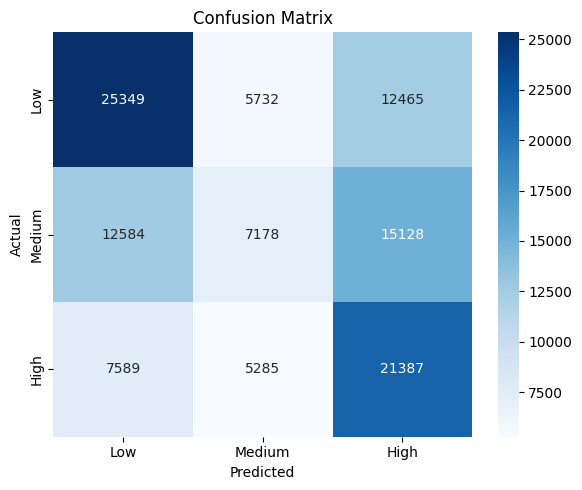


📊 Feature Importances Table:
            Feature  Importance
0             Month    0.306281
4       Mean_Temp_C    0.281427
1               Day    0.148353
5   Total_Precip_mm    0.090742
2       day_of_week    0.084944
3        is_weekend    0.028410
8  temp_range_vec_2    0.026524
6  temp_range_vec_0    0.017037
7  temp_range_vec_1    0.016282


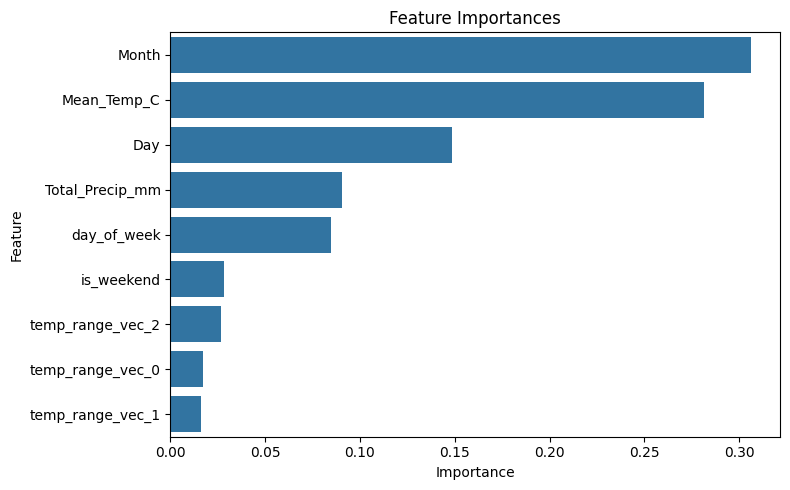

In [3]:
# ---------------------------------------------
# STEP 1: Import libraries and start Spark
# ---------------------------------------------
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Start Spark session
spark = SparkSession.builder.appName("TrafficModelEvaluation").getOrCreate()

# ---------------------------------------------
# STEP 2: Load predictions and trained model
# ---------------------------------------------
predictions = spark.read.parquet("traffic_optimized_predictions.parquet")
model = CrossValidatorModel.load("traffic_optimized_model")
rf_model = model.bestModel.stages[-1]  # RandomForestClassifier is the last stage

# ---------------------------------------------
# STEP 3: Metrics
# ---------------------------------------------
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
f1 = evaluator.setMetricName("f1").evaluate(predictions)
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"🎯 F1 Score: {f1:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"🔄 Recall: {recall:.4f}")

# ---------------------------------------------
# STEP 4: Confusion Matrix
# ---------------------------------------------
pandas_df = predictions.select("label", "prediction").toPandas()
conf_mat = confusion_matrix(pandas_df["label"], pandas_df["prediction"])

print("\n📊 Confusion Matrix:")
print(conf_mat)

print("\n📋 Classification Report:")
print(classification_report(pandas_df["label"], pandas_df["prediction"]))

# ---------------------------------------------
# STEP 5: Plot Confusion Matrix
# ---------------------------------------------
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ---------------------------------------------
# STEP 6: Feature Importances
# ---------------------------------------------
# List of features in order (based on your vector assembler)
feature_names = [
    "Month",
    "Day",
    "day_of_week",
    "is_weekend",
    "Mean_Temp_C",
    "Total_Precip_mm",
    "temp_range_vec_0",  # OneHotEncoder for Low
    "temp_range_vec_1",  # OneHotEncoder for Medium
    "temp_range_vec_2"   # OneHotEncoder for High
]

# Get importances
importances = rf_model.featureImportances.toArray()

# Build DataFrame
importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Show importance table
print("\n📊 Feature Importances Table:")
print(importances_df)

# ---------------------------------------------
# STEP 7: Plot Feature Importances
# ---------------------------------------------
plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=importances_df)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()
